In [5]:
import keras
import tensorflow as tf
import numpy as np
from keras.src.models import Sequential
from keras.src.layers import Conv2D, ReLU,MaxPooling2D, Dense, Dropout, Flatten, Input, LeakyReLU, GlobalAveragePooling2D, BatchNormalization
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Lambda, Normalization
from sklearn.utils.class_weight import compute_class_weight
from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.src.regularizers import L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import cv2

dir_original_data = "/kaggle/input/chest-temp"

train_dataset = keras.utils.image_dataset_from_directory(
    dir_original_data,
    labels="inferred",
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    color_mode= 'rgb',
    seed=42,
    image_size=(256, 256)
)

test_dataset = keras.utils.image_dataset_from_directory(
    dir_original_data,
    labels="inferred",
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    color_mode = 'rgb',
    seed=42,
    image_size=(256, 256)
)

data_augumentation =Sequential([
    RandomFlip("horizontal"),          
    RandomRotation(factor=2/360),                     
    RandomZoom(0.02),                              
    RandomTranslation(height_factor=0.02, width_factor=0.02),  
])

def histogram_equalization(image):
    def _equalize(img):
        img = img.astype(np.uint8)
        r, g, b = cv2.split(img)
        r = cv2.equalizeHist(r)
        g = cv2.equalizeHist(g)
        b = cv2.equalizeHist(b)
        return cv2.merge([r, g, b])
        
    equalized = tf.numpy_function(_equalize, [image], tf.uint8)
    equalized.set_shape([256, 256, 3])
    equalized = tf.cast(equalized,tf.float32)
    
    return equalized

def change_range(image):
    return (image - 127.5) / 127.5
    
def preprocess_train(image,label):
    image = histogram_equalization(image)
    image = change_range(image)
    image = data_augumentation(image)
    return image,label

def preprocess_test(image,label):
    image = histogram_equalization(image)
    image = change_range(image)
    return image,label


train_dataset = train_dataset.unbatch()
test_dataset = test_dataset.unbatch()

train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(3200).repeat().batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])
with strategy.scope():

    model = Sequential([ 
    
    Input(shape=(256, 256, 3)),

    Conv2D(32, (7, 7), strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    MaxPooling2D((3, 3), strides=2),
    
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.01),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    
    Dense(4, activation='softmax',kernel_regularizer=L2(0.001))
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

model.summary()


2025-05-05 13:31:43.140503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746451903.164033    5914 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746451903.171296    5914 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 21165 files belonging to 4 classes.
Using 16932 files for training.


I0000 00:00:1746451923.788438    5914 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746451923.789239    5914 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 31, 31, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 31, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 31, 31, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 31, 31, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 31, 31, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 128)         │              

 Total params: 4,716,676 (17.99 MB)

 Trainable params: 4,712,772 (17.98 MB)

 Non-trainable params: 3,904 (15.25 KB)

In [6]:
# import keras
# import tensorflow as tf
# import numpy as np
# from keras.src.models import Sequential
# from keras.src.layers import Conv2D, ReLU,MaxPooling2D, Dense, Dropout, Flatten, Input, LeakyReLU, GlobalAveragePooling2D, BatchNormalization, RandomFlip, RandomRotation, Rescaling,RandomZoom
# from sklearn.utils.class_weight import compute_class_weight
# from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# from keras.src.regularizers import L2
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.vgg19 import preprocess_input
# from keras.models import Model

# dir_original_data = "/kaggle/input/chest-temp"

# train_dataset = keras.utils.image_dataset_from_directory(
#     dir_original_data,
#     labels="inferred",
#     label_mode='categorical',
#     validation_split=0.2,
#     subset='training',
#     seed=42,
#     image_size=(224, 224)
# )

# test_dataset = keras.utils.image_dataset_from_directory(
#     dir_original_data,
#     labels="inferred",
#     label_mode='categorical',
#     validation_split=0.2,
#     subset='validation',
#     seed=42,
#     image_size=(224, 224)
# )

# data_augumentation_test = Sequential([
#     Rescaling(1./255.)
# ])

# data_augmentation_train = Sequential([
#     Rescaling(1./255.),
#     RandomFlip("horizontal"),
#     RandomRotation(0.2),
# ])

# def preprocess_train(image,label):
#     image = data_augmentation_train(image)
#     image = preprocess_input(image)

#     return image,label

# def preprocess_test(image,label):
#     image = data_augumentation_test(image)
#     image = preprocess_input(image)

#     return image,label


# train_dataset = train_dataset.map(preprocess_train)
# test_dataset = test_dataset.map(preprocess_test)
    

# strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])
# with strategy.scope():
#     base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))

#     x = base_model.output

#     x = GlobalAveragePooling2D()(x)
#     x = Dense(512)(x)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = Dropout(0.5)(x)
#     output = Dense(4, activation='softmax')(x)
    
    
#     model = Model(inputs=base_model.input, outputs=output)

#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

# model.summary()
    

In [7]:
# import numpy as np
# labels = []
# for _, y in train_dataset.unbatch():
#     labels.append(np.argmax(y.numpy()))
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(labels),
#     y=labels
# )
# class_weights = dict(enumerate(class_weights))

# print(class_weights)

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/kaggle/working/chest_class.keras', save_best_only=True, monitor='val_loss')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=4, min_lr=1e-12)

history = model.fit(
    train_dataset,
    steps_per_epoch = 16932//32,
    epochs=100,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight = {0: 1.4581467447468137, 1: 0.8733237053847741, 2: 0.5204081632653061, 3: 4.03912213740458}
)

Epoch 1/100


E0000 00:00:1746451963.832809    5914 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1746451964.859692    5972 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746451965.175786    5974 cuda_dnn.cc:529] Loaded cuDNN version 90300


529/529 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5676 - auc: 0.8170 - loss: 0.9229

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


529/529 ━━━━━━━━━━━━━━━━━━━━ 176s 305ms/step - accuracy: 0.5677 - auc: 0.8171 - loss: 0.9226 - val_accuracy: 0.6235 - val_auc: 0.8705 - val_loss: 0.9045 - learning_rate: 0.0010
Epoch 2/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 158s 298ms/step - accuracy: 0.7239 - auc: 0.9179 - loss: 0.6001 - val_accuracy: 0.5489 - val_auc: 0.8376 - val_loss: 1.1014 - learning_rate: 0.0010
Epoch 3/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 165s 313ms/step - accuracy: 0.7772 - auc: 0.9426 - loss: 0.4879 - val_accuracy: 0.6571 - val_auc: 0.8883 - val_loss: 0.9000 - learning_rate: 0.0010
Epoch 4/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 162s 307ms/step - accuracy: 0.7962 - auc: 0.9517 - loss: 0.4394 - val_accuracy: 0.4152 - val_auc: 0.7740 - val_loss: 1.8383 - learning_rate: 0.0010
Epoch 5/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 164s 310ms/step - accuracy: 0.8171 - auc: 0.9582 - loss: 0.4127 - val_accuracy: 0.6878 - val_auc: 0.9065 - val_loss: 0.8081 - learning_rate: 0.0010
Epoch 6/100
529/529 ━━━━━━━━━━━━━━━━━━━━ 164s 310ms/step - accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

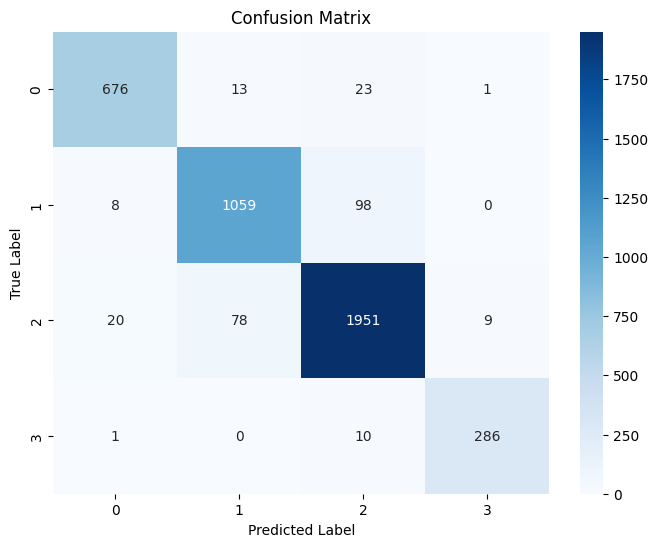

Accuracy: 93.83%


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# model = keras.saving.load_model("/kaggle/working/chest_class.keras")

predictions = []
real_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predictions.extend(np.argmax(preds, axis=1)) 
    real_labels.extend(np.argmax(labels.numpy(), axis=1)) 

cm = confusion_matrix(real_labels, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(real_labels, predictions)
print(f"Accuracy: {accuracy:.2%}")

In [12]:
from sklearn.metrics import classification_report

print(classification_report(real_labels, predictions))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       713
           1       0.92      0.91      0.91      1165
           2       0.94      0.95      0.94      2058
           3       0.97      0.96      0.96       297

    accuracy                           0.94      4233
   macro avg       0.95      0.94      0.94      4233
weighted avg       0.94      0.94      0.94      4233

